SSAM
--

**Plots a spectrogram of single component of seismic (or acoustic) data. Can plot a single or multiple days of data. Plotting any more than three days is very slow, and is *not* recommended. Spectrogram data are *not* stored following plotting.**

* Data are acquired from GeoNet's FDSN web servers, http://www.geonet.org.nz/data/tools/FDSN. The archive server is used as the first choice, and if that does not contain the data (it only keeps data older than 7 days) then the near real-time server will be used instead.
* Data are decimated to 50 sps, giving a maximum displayed frequency of 25 Hz.
* Data windows do not overlap.
* Data window length is 3 minutes.
* Frequency resolution is 0.1 Hz. Each FFT is resampled to achieve this.
* Sensitivity is removed from the raw data to give m/s, then converted to nm/s.
* Data gaps are interpolated as zeros, so time with a data gap gives zero FFT, hence a blank space in the spectrogram. 
* Colour map is bounded by 10 and 5e6. This is fixed so that all spectrogram have the same colour map.

In [1]:
#import modules
import numpy as np
from numpy.fft import rfft
from obspy.core import read, Trace, Stream, UTCDateTime
from obspy.signal.invsim import cosine_taper
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as dates
from datetime import datetime, timedelta
import pandas as pd

%matplotlib inline

In [2]:
#data window (seconds), should be a finite fraction of an hour
win = 180
#frequency interval (hertz)
fint = 0.1

In [3]:
#GeoNet's FDSN web servers
arc_client = 'http://service.geonet.org.nz'
nrt_client = 'http://beta-service-nrt.geonet.org.nz'

In [4]:
#function to get a stream from an FDSN client
def dayswave(date1, date2, net, sta, loc, cmp):
  #get data from a FDSN web server for days date1 to date2 inclusive
  global st
  time1 = UTCDateTime(date1)
  time2 = UTCDateTime(date2)
  #st = client.get_waveforms(net, sta, loc, cmp, time1, time2 + 86400, attach_response=True)
  try:
    client = Client(arc_client)
    st = client.get_waveforms(net, sta, loc, cmp, time1, time2 + 86400, attach_response=True)
    print 'arc client successful'
    #if this raises an exception, try the near real-time server
  except:
    client = Client(nrt_client)
    st = client.get_waveforms(net, sta, loc, cmp, time1, time2 + 86400, attach_response=True)
    print 'nrt client successful'

<span style="color:red">**This cell to be set by user**</span>

In [5]:
date1 = '2017-11-09' #(first date to plot)
date2 = '2017-11-09' #(last date to plot)
site = 'MAVZ.10.HHZ.NZ'
normalise = 'log'
#normalise = 'lin'

In [6]:
#split site into components
sta = site.split('.')[0]
loc = site.split('.')[1]
cmp = site.split('.')[2]
net = site.split('.')[3]

In [7]:
#get data stream
dayswave(date1, date2, net, sta, loc, cmp)
st.remove_sensitivity()

#merge streams, fill gaps with zeros
st.merge(fill_value = 0.0)
tr = st[0]

#decimate trace to 50 sps, no need for higher frequencies
if (tr.stats.sampling_rate == 100.0):
    tr.decimate(factor=2, strict_length=False)

arc client successful


In [8]:
#set start,end times for the days, from input dates
year1 = int(date1.split('-')[0])
month1 = int(date1.split('-')[1])
day1 = int(date1.split('-')[2])
start = UTCDateTime(year1, month1, day1, 0, 0, 0)
year2 = int(date2.split('-')[0])
month2 = int(date2.split('-')[1])
day2 = int(date2.split('-')[2])
start2 = UTCDateTime(year2, month2, day2, 0, 0, 0)
end = start2 + 86400

#number of days of data
ndays = int((end - start)/86400)

In [9]:
#create an empty 2d array of the required size and fill with zeros
nwin = ndays*24*(3600/180) #number windows in ndays hours
z = np.zeros((249,nwin))

In [10]:
#FFT for each window in data, load into an array z
t = start
#loop through data in 'win' sec blocks
col = 0 #columns of 2d array
while t < end:
    #slice win seconds of data
    tr10 = tr.slice(t, t + win)
    #only proceed if have complete data for this time window
    if (len(tr10) >= win * 50):
     tr10.detrend(type='demean')
     npts, nyq = tr10.stats.npts, tr10.stats.sampling_rate/2.0
     #cosine taper
     tap = cosine_taper(npts,0.1)
     #calculate fft
     data = tr10.data * 1e9 #convert from m/s to nm/s
     trf = rfft(data*tap)
     a = abs(trf[1:])
     #calculate frequencies for fft
     freq = np.linspace(0,nyq,npts/2)
     #interpolate to 0.1 Hz (lower resolution)
     f = np.arange(0.1,nyq,0.1) #0.1 Hz frequencies
     da = np.interp(f, freq, a)
     #fill column with spectral data
     z[:,col] = da
    
    #next window
    col += 1
    t += win

In [11]:
#array for x-axis values
dstart = datetime.strptime(date1, '%Y-%m-%d')
dend = datetime.strptime(date2, '%Y-%m-%d') + timedelta(days=1)
x = pd.date_range(start=dstart, end=dend, freq='3min')

#array for hourly x-axis ticks/grid
xticks = pd.date_range(start=dstart, end=dend, freq='H')

#label for every 3 hours, replace other labels with a blank string
xlabels = xticks.strftime('%m-%d/%H:%M')
idx = 0
for val in xlabels:
    if (idx%3 != 0):
        xlabels[idx] = ''
    idx += 1

In [12]:
#boundaries of cmap, nm/s
#this ensures all spectrograms use the same colour map
vmin = 10
vmax = 5e6

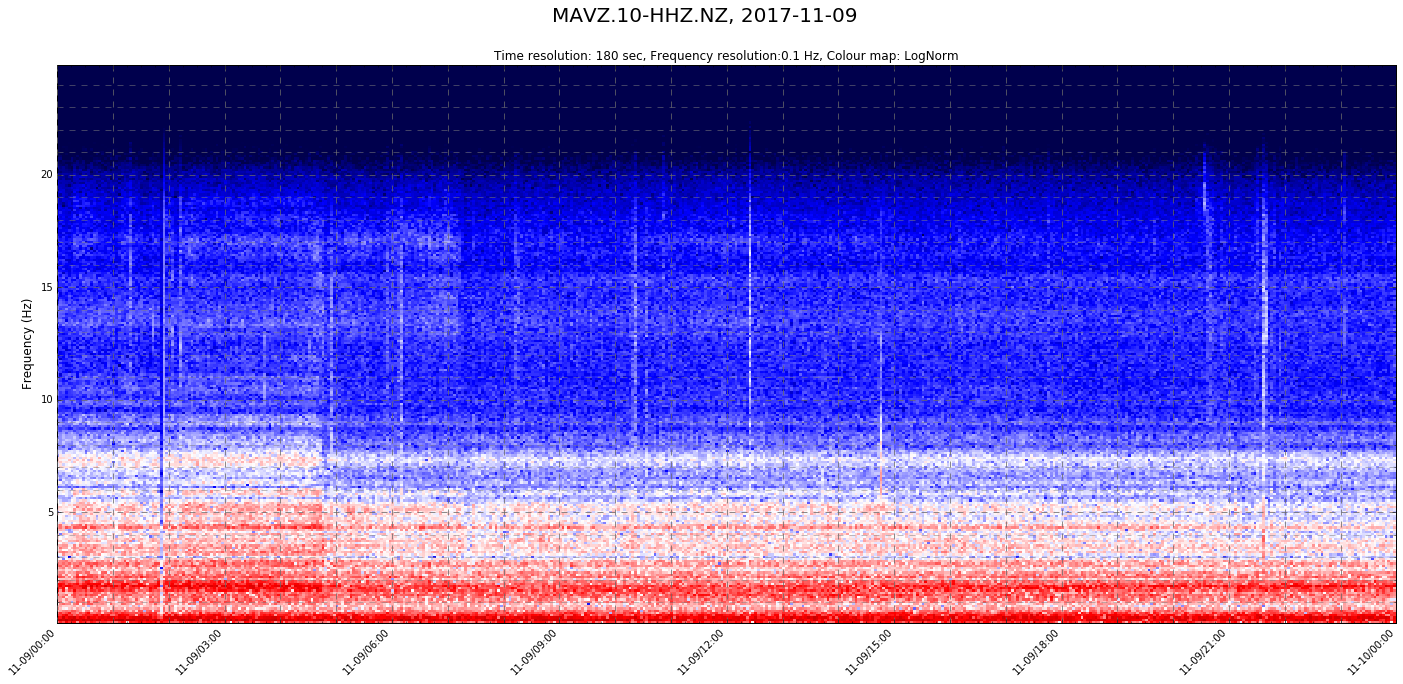

In [13]:
fig,ax = plt.subplots(figsize=(24,10))

if (normalise == 'log'):
    ax.pcolormesh(x, f, z, cmap='seismic', norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    title = 'Time resolution: '+str(win)+' sec, Frequency resolution:'+str(fint)+' Hz, Colour map: LogNorm'
if (normalise == 'lin')    :
    ax.pcolormesh(x, f, z, cmap='seismic', norm=matplotlib.colors.Normalize(vmin=vmin, vmax=vmax))
    title = 'Time resolution: '+str(win)+' sec, Frequency resolution:'+str(fint)+' Hz, Colour map: Linear'

fmt = dates.DateFormatter('%m-%d/%H')
ax.xaxis.set_major_formatter(fmt)
ax.set_ylim(f.min(), f.max())
ax.set_ylabel('Frequency (Hz)', fontsize=12)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=45, horizontalalignment='right')
ax.grid(b=True, which='major', color='dimgray', linestyle='--', linewidth=0.75)
ax.grid(b=True, which='minor', color='gray', linestyle='--', axis='y')
plt.minorticks_on()

#titles
if (date2 == date1):
    suptitle = sta+'.'+loc+'-'+cmp+'.'+net+', '+date1
else:
    suptitle = sta+'.'+loc+'-'+cmp+'.'+net+', '+date1+' to '+date2
plt.suptitle(suptitle, fontsize=20)
plt.title(title, fontsize=12)
plt.savefig('ssam.png', dpi=200)